# Customer Behavioral Segmentation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

In [2]:
df1 = pd.read_csv('large_data/DEVICE_DIRECTORY.csv')

In [3]:
df2 = pd.read_csv('large_data/SUB_DEVICE_DIRECTORY.csv')

In [4]:
pd.set_option('display.max_columns',None)

### Adjusting dates and creating 'DEVICE_AGE' column which shows the the number of days customers take to adopt a device after its release.

In [5]:
df = pd.merge(df2, df1, how='left', left_on='DEVICE_ID', right_on='TAC')
df = df.drop(['TAC', 'MODEL_NAME', 'VENDOR_NAME'], axis=1) # Duplicate columns

df['START_DATE'] = pd.to_datetime(df['START_DATE'], errors='coerce')
df['RELEASE_DATE'] = pd.to_datetime(df['RELEASE_DATE'], errors='coerce')

# Adjusting all 'START_DATE' to the last day of the same month to avoid date-related miscalculations
def adjust_start_date(date):
    if date.month in [4, 6, 9, 11]: 
        return date.replace(day=30)
    elif date.month == 2:  # February, handling leap year
        if date.year % 4 == 0 and (date.year % 100 != 0 or date.year % 400 == 0):
            return date.replace(day=29)  
        else:
            return date.replace(day=28) 
    else:
        return date.replace(day=31)  

df['START_DATE'] = df['START_DATE'].apply(adjust_start_date)

# Creating a column 'DEVICE_AGE' that calculates the difference in days between START_DATE and RELEASE_DATE
df['DEVICE_AGE'] = (df['START_DATE'] - df['RELEASE_DATE']).dt.days

# Filtering out rows where 'DEVICE_AGE' is positive
df = df[df['DEVICE_AGE'] >= 0]

df.head()

,ID,DEVICE_ID,BRAND,MODEL,NETTYPE,OS,OS_TYPE_x,START_DATE,END_DATE,DAYS_USED,AVG_DAYS_USED,SUPPORTS_LTE,SUPPORTS_VOLTE,BATTERY_CAPACITY,BATTERY_TYPE,BODY_DEPTH,BODY_HEIGHT,BODY_WIDTH,BODY_TYPE,OS_TYPE_y,OS_VENDOR,CAMERA_FLASHLIGHT,SUPPORTS_MULTISIM,SUPPORTS_ESIM,SUPPORT_5G,SIM_COUNT,CPU_CORES,MULTISIM_MODE,PIXEL_DENSITY,RAM_SIZE,RELEASE_DATE,BAND_1800,BAND_1900,BAND_850,BAND_900,DEVICE_AGE
0,4397787,35230713,Samsung,Galaxy A12,4G,Android,smartphone,2024-01-31,2024-07-12,193,616.0,1,1,5000.0,Li-ion,8.9,164.0,75.80,touch,Android,Google,1,1,0,0,2,8,dual standby,264.0,6156,2020-08-19,1,1,1,1,1260
1,4129638,35306809,Apple,iPhone SE,4G,iOS,smartphone,2022-04-30,2023-05-31,425,642.5,1,0,1642.0,Li-ion,7.6,123.8,58.60,touch,iOS,Apple,1,0,0,0,1,2,Standby,326.0,2048,2016-03-01,1,1,1,1,2251
2,1154183,86887805,OnePlus,Nord N100,4G,Android,smartphone,2021-11-30,2024-07-12,984,564.8,1,1,5000.0,Li-polymer,8.5,164.9,75.10,touch,Android,Google,1,1,0,0,2,8,dual standby,269.0,6156,2020-05-21,1,1,1,1,558
3,670331,86296505,Xiaomi,Redmi 9T,4G,Android,smartphone,2021-05-31,2024-02-29,1034,624.8,1,1,6000.0,Li-polymer,9.6,162.3,77.28,touch,Android,Google,0,1,0,0,2,8,Standby,395.0,4096,2021-01-01,1,1,1,1,150
4,3074468,35639208,Samsung,Galaxy J7 2017 Dual,4G,Android,smartphone,2021-10-31,2021-10-31,30,653.4,1,1,3600.0,Li-ion,7.8,152.4,74.70,touch,Android,Google,1,1,0,0,2,8,Standby,401.0,3072,2017-07-01,1,1,1,1,1583


In [6]:
del df1, df2

### Creating a new dataframe with the latest devices for each customer.

In [7]:
new_df = df.copy()
new_df = new_df.loc[new_df.groupby('ID')['START_DATE'].idxmax()]

cols = new_df.columns.tolist()
release_index = cols.index('RELEASE_DATE')
start_index = cols.index('START_DATE')
cols.insert(start_index, cols.pop(release_index)) 
new_df = new_df[cols]

cols = new_df.columns.tolist()
release_index = cols.index('RELEASE_DATE')  
cols.insert(release_index, cols.pop(cols.index('DEVICE_AGE'))) 
new_df = new_df[cols]

new_df.head()

,ID,DEVICE_ID,BRAND,MODEL,NETTYPE,OS,OS_TYPE_x,DEVICE_AGE,RELEASE_DATE,START_DATE,END_DATE,DAYS_USED,AVG_DAYS_USED,SUPPORTS_LTE,SUPPORTS_VOLTE,BATTERY_CAPACITY,BATTERY_TYPE,BODY_DEPTH,BODY_HEIGHT,BODY_WIDTH,BODY_TYPE,OS_TYPE_y,OS_VENDOR,CAMERA_FLASHLIGHT,SUPPORTS_MULTISIM,SUPPORTS_ESIM,SUPPORT_5G,SIM_COUNT,CPU_CORES,MULTISIM_MODE,PIXEL_DENSITY,RAM_SIZE,BAND_1800,BAND_1900,BAND_850,BAND_900
8167674,1,35579407,Apple,iPhone SE,4G,iOS,smartphone,486,2016-03-01,2017-06-30,2019-10-31,882,642.5,1,0,1642.0,Li-ion,7.60,123.80,58.60,touch,iOS,Apple,1,0,0,0,1,8,Standby,326.0,2048,1,1,1,1
6428652,2,86221906,Xiaomi,Redmi 12,4G,Android,smartphone,392,2023-01-04,2024-01-31,2024-07-12,193,226.1,1,1,5000.0,Li-ion,8.17,168.60,76.28,touch,Android,Google,0,1,0,0,2,8,dual standby,396.0,4096,1,1,1,1
19081,5,86095705,Xiaomi,Redmi 9,4G,Android,smartphone,1247,2020-04-01,2023-08-31,2024-07-12,346,645.2,1,1,5020.0,Li-ion,9.10,163.32,77.01,touch,Android,Google,1,1,0,0,2,8,Standby,395.0,3072,1,1,1,1
1244379,6,86252506,Xiaomi,Redmi 9C,4G,Android,smartphone,791,2020-07-31,2022-09-30,2024-07-12,680,559.1,1,1,5000.0,Li-polymer,9.00,164.90,77.00,touch,Android,Google,1,1,0,0,2,8,dual standby,269.0,2048,1,1,1,1
1811256,7,35657309,Samsung,Galaxy A3 2017,4G,Android,smartphone,2310,2017-01-01,2023-04-30,2024-07-12,468,730.3,1,0,2350.0,Li-ion,7.90,135.40,66.20,touch,Android,Google,1,0,0,0,1,8,Standby,312.0,2048,1,1,1,1


# Purchasing behavior: Understanding device adoption patterns

##### Segmenting customers based on the time they take (in days) to adopt a device after its release.

In [8]:
new_df = new_df[new_df['DEVICE_AGE'] <= 7300]
new_df['DEVICE_AGE'].describe()

count    2.972988e+06
mean     9.644869e+02
std      7.891294e+02
min      0.000000e+00
25%      3.570000e+02
50%      6.890000e+02
75%      1.399000e+03
max      7.287000e+03
Name: DEVICE_AGE, dtype: float64

### Defining the thresholds

In [9]:
Q1 = new_df['DEVICE_AGE'].quantile(0.25)  # 1st quartile for Early Adopters 
Q2 = new_df['DEVICE_AGE'].quantile(0.50)  # Median for Mid-range Adopters
Q3 = new_df['DEVICE_AGE'].quantile(0.75)  # 3rd quartile for Late Adopters
innovator_threshold = 60  # Innovators, purchasing within 60 days

### Spread and distribution of 'DEVICE_AGE'

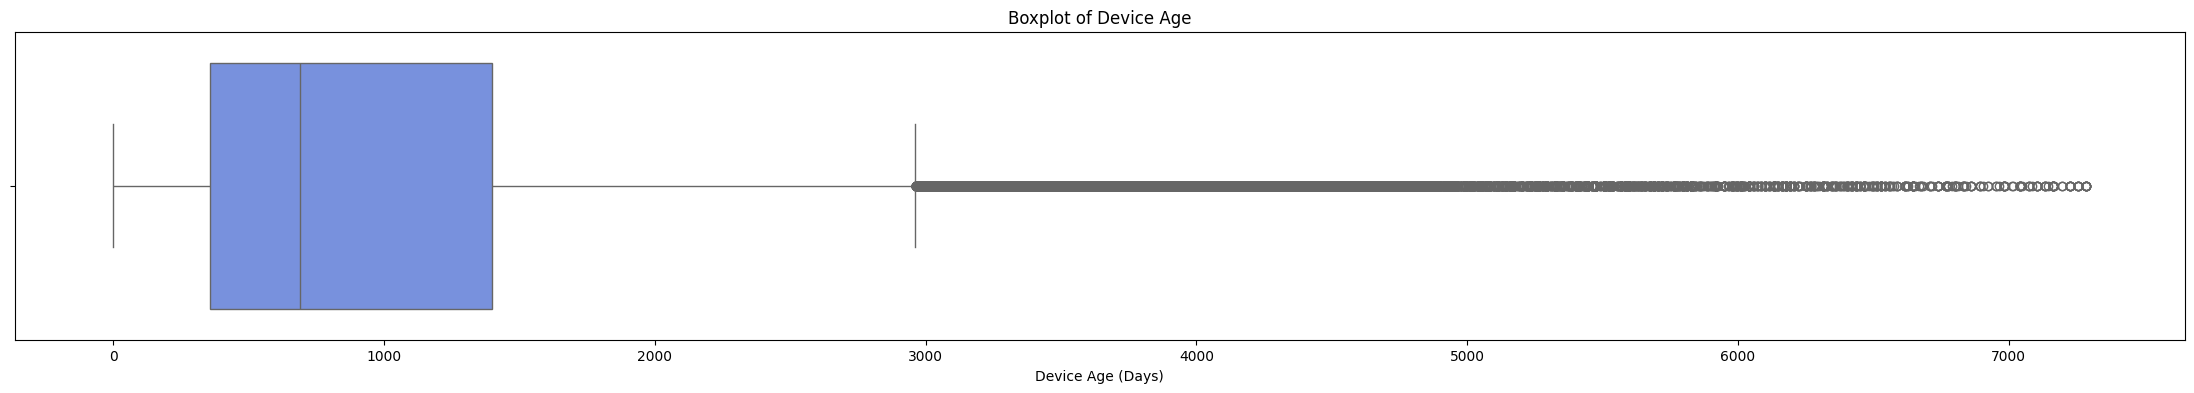

In [10]:
coolwarm_colors = sns.color_palette('coolwarm', as_cmap=False)

plt.figure(figsize=(28, 4))
sns.boxplot(x=new_df['DEVICE_AGE'], color=coolwarm_colors[0])
plt.title('Boxplot of Device Age')
plt.xlabel('Device Age (Days)')
plt.show()

In [11]:
def segment_by_device_age(age):
    if age <= innovator_threshold: 
        return 'Innovator'
    elif age <= Q1: 
        return 'Early Adopter'
    elif age <= Q2:  
        return 'Mid-range Adopter'
    elif age <= Q3: 
        return 'Late Adopter'
    else: 
        return 'Laggard'

new_df['ADOPTER_CATEGORY'] = new_df['DEVICE_AGE'].apply(segment_by_device_age)
new_df.head()

,ID,DEVICE_ID,BRAND,MODEL,NETTYPE,OS,OS_TYPE_x,DEVICE_AGE,RELEASE_DATE,START_DATE,END_DATE,DAYS_USED,AVG_DAYS_USED,SUPPORTS_LTE,SUPPORTS_VOLTE,BATTERY_CAPACITY,BATTERY_TYPE,BODY_DEPTH,BODY_HEIGHT,BODY_WIDTH,BODY_TYPE,OS_TYPE_y,OS_VENDOR,CAMERA_FLASHLIGHT,SUPPORTS_MULTISIM,SUPPORTS_ESIM,SUPPORT_5G,SIM_COUNT,CPU_CORES,MULTISIM_MODE,PIXEL_DENSITY,RAM_SIZE,BAND_1800,BAND_1900,BAND_850,BAND_900,ADOPTER_CATEGORY
8167674,1,35579407,Apple,iPhone SE,4G,iOS,smartphone,486,2016-03-01,2017-06-30,2019-10-31,882,642.5,1,0,1642.0,Li-ion,7.60,123.80,58.60,touch,iOS,Apple,1,0,0,0,1,8,Standby,326.0,2048,1,1,1,1,Mid-range Adopter
6428652,2,86221906,Xiaomi,Redmi 12,4G,Android,smartphone,392,2023-01-04,2024-01-31,2024-07-12,193,226.1,1,1,5000.0,Li-ion,8.17,168.60,76.28,touch,Android,Google,0,1,0,0,2,8,dual standby,396.0,4096,1,1,1,1,Mid-range Adopter
19081,5,86095705,Xiaomi,Redmi 9,4G,Android,smartphone,1247,2020-04-01,2023-08-31,2024-07-12,346,645.2,1,1,5020.0,Li-ion,9.10,163.32,77.01,touch,Android,Google,1,1,0,0,2,8,Standby,395.0,3072,1,1,1,1,Late Adopter
1244379,6,86252506,Xiaomi,Redmi 9C,4G,Android,smartphone,791,2020-07-31,2022-09-30,2024-07-12,680,559.1,1,1,5000.0,Li-polymer,9.00,164.90,77.00,touch,Android,Google,1,1,0,0,2,8,dual standby,269.0,2048,1,1,1,1,Late Adopter
1811256,7,35657309,Samsung,Galaxy A3 2017,4G,Android,smartphone,2310,2017-01-01,2023-04-30,2024-07-12,468,730.3,1,0,2350.0,Li-ion,7.90,135.40,66.20,touch,Android,Google,1,0,0,0,1,8,Standby,312.0,2048,1,1,1,1,Laggard


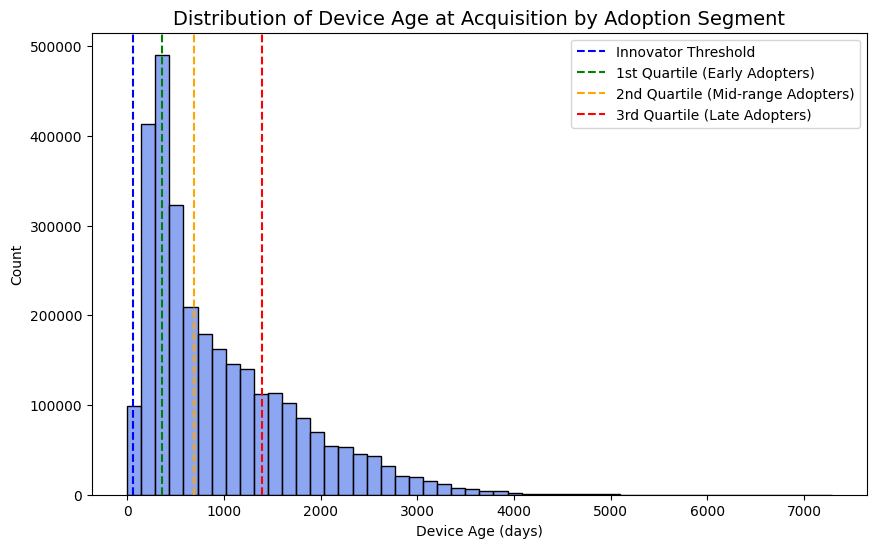

In [12]:
coolwarm_colors = sns.color_palette('coolwarm', as_cmap=False)
plt.figure(figsize=(10, 6))
sns.histplot(new_df['DEVICE_AGE'], bins=50, kde=False, color=coolwarm_colors[0])

plt.axvline(innovator_threshold, color='blue', linestyle='--', label='Innovator Threshold')
plt.axvline(Q1, color='green', linestyle='--', label='1st Quartile (Early Adopters)')
plt.axvline(Q2, color='orange', linestyle='--', label='2nd Quartile (Mid-range Adopters)')
plt.axvline(Q3, color='red', linestyle='--', label='3rd Quartile (Late Adopters)')

plt.title('Distribution of Device Age at Acquisition by Adoption Segment', fontsize=14)
plt.xlabel('Device Age (days)', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.legend()
plt.show()

# Customer upgrading patterns

##### This analysis identifies how often customers switch devices, highlighting segments such as rare upgraders, frequent upgraders, and etc.

In [13]:
# Calculating the frequency of device changes per user
user_device_count = df.groupby('ID').size().reset_index(name='DEVICE_COUNT')
df = df.merge(user_device_count, on='ID', how='left')

### Defining the thresholds

In [14]:
rare_threshold = user_device_count['DEVICE_COUNT'].quantile(0.25) # 2 device changes
moderate_threshold = user_device_count['DEVICE_COUNT'].quantile(0.50) # 4 device changes
frequent_threshold = user_device_count['DEVICE_COUNT'].quantile(0.75) # 5 device changes

### 1. Rare Upgraders

In [15]:
rare_users = user_device_count[user_device_count['DEVICE_COUNT'] <= rare_threshold]
rare_df = df[df['ID'].isin(rare_users['ID'])].copy()

rare_df['CATEGORY'] = 'Rare Upgraders'

### 2. Moderate Upgraders

In [16]:
moderate_users = user_device_count[
    (user_device_count['DEVICE_COUNT'] > rare_threshold) & 
    (user_device_count['DEVICE_COUNT'] <= moderate_threshold)
]
moderate_df = df[df['ID'].isin(moderate_users['ID'])].copy()

moderate_df['CATEGORY'] = 'Moderate Upgraders'

### 3. Frequent Upgraders

In [17]:
frequent_users = user_device_count[
    (user_device_count['DEVICE_COUNT'] > moderate_threshold) & 
    (user_device_count['DEVICE_COUNT'] <= frequent_threshold)
]
frequent_df = df[df['ID'].isin(frequent_users['ID'])].copy()

frequent_df['CATEGORY'] = 'Frequent Upgraders'

### 4. Super Frequent Upgraders

In [18]:
super_frequent_users = user_device_count[user_device_count['DEVICE_COUNT'] > frequent_threshold]
super_frequent_df = df[df['ID'].isin(super_frequent_users['ID'])].copy()

super_frequent_df['CATEGORY'] = 'Super Frequent Upgraders'

### Combining all sub-segments into one dataframe 

In [19]:
purchasing_behavior_df = pd.concat([rare_df, moderate_df, frequent_df, super_frequent_df], ignore_index=True)

In [20]:
purchasing_behavior_df['START_DATE'] = pd.to_datetime(purchasing_behavior_df['START_DATE'], errors='coerce')
purchasing_behavior_df['END_DATE'] = pd.to_datetime(purchasing_behavior_df['END_DATE'], errors='coerce')

# Sorting by user ID and start date to get the device sequence for each user
purchasing_behavior_df = purchasing_behavior_df.sort_values(by=['ID', 'START_DATE'])
purchasing_behavior_df['NEXT_START_DATE'] = purchasing_behavior_df.groupby('ID')['START_DATE'].shift(-1)

# Calculating time to switch, considering the last device switch as having no subsequent switch
purchasing_behavior_df['TIME_TO_SWITCH'] = (purchasing_behavior_df['NEXT_START_DATE'] - purchasing_behavior_df['END_DATE']).dt.days
purchasing_behavior_df['TIME_TO_SWITCH'] = purchasing_behavior_df['TIME_TO_SWITCH'].fillna(-1)

# Correcting negative time to switch (indicating simultaneous device usage or no subsequent device)
purchasing_behavior_df['TIME_TO_SWITCH'] = purchasing_behavior_df['TIME_TO_SWITCH'].apply(lambda x: max(x, 0))

# Assigning category to indicate no subsequent device for the last one
purchasing_behavior_df['CATEGORY'] = purchasing_behavior_df['CATEGORY'].fillna('Last Device')

time_to_switch_summary = purchasing_behavior_df.groupby('CATEGORY')['TIME_TO_SWITCH'].describe()
time_to_switch_summary

,count,mean,std,min,25%,50%,75%,max
CATEGORY,,,,,,,,
Frequent Upgraders,1862335.0,119.314501,289.346061,0.0,0.0,31.0,31.0,3591.0
Moderate Upgraders,3435870.0,130.776117,362.994218,0.0,0.0,30.0,31.0,3835.0
Rare Upgraders,1355811.0,106.967589,428.914952,0.0,0.0,0.0,30.0,3896.0
Super Frequent Upgraders,5665467.0,104.143740,225.703160,0.0,28.0,31.0,60.0,3591.0


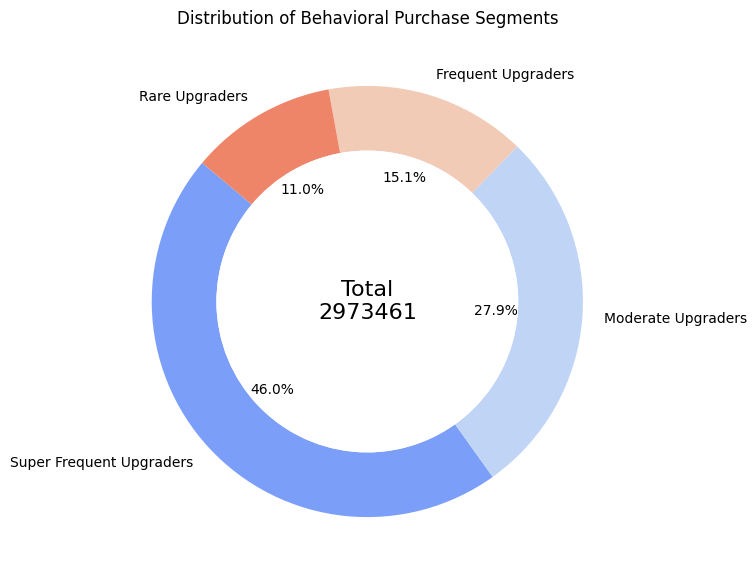

In [21]:
behavioral_purchase_distribution = purchasing_behavior_df['CATEGORY'].value_counts()

total_users = purchasing_behavior_df['ID'].nunique()

plt.figure(figsize=(7, 7))
colors = sns.color_palette('coolwarm', len(behavioral_purchase_distribution))
plt.pie(behavioral_purchase_distribution, labels=behavioral_purchase_distribution.index, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops=dict(width=0.3))

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.text(0, 0, f'Total\n{total_users}', ha='center', va='center', fontsize=16)
plt.title('Distribution of Behavioral Purchase Segments')
plt.show()

# Customer loyalty towards brands

##### This analysis identifies how consistently a customer sticks with the same brand across multiple device purchases.

In [22]:
# Calculating total days a customer has used devices
user_total_days_used = df.groupby('ID')['DAYS_USED'].sum().reset_index(name='TOTAL_DAYS_USED')

# Calculating how many times the customer sticks with the same brand
brand_loyalty = df.groupby(['ID', 'BRAND']).size().reset_index(name='BRAND_COUNT')
brand_loyalty = brand_loyalty.groupby('ID')['BRAND_COUNT'].max().reset_index(name='MAX_BRAND_COUNT')

# Calculating total number of devices a customer has
total_devices_used = df.groupby('ID').size().reset_index(name='TOTAL_DEVICES')
loyalty_df = pd.merge(user_total_days_used, brand_loyalty, on='ID')
loyalty_df = pd.merge(loyalty_df, total_devices_used, on='ID')

# Calculating brand loyalty as a percentage of total devices used from the same brand (most used one)
loyalty_df['BRAND_LOYALTY'] = (loyalty_df['MAX_BRAND_COUNT'] / loyalty_df['TOTAL_DEVICES']) * 100

loyalty_df = pd.merge(loyalty_df, df[['ID', 'BRAND']], on='ID')

In [23]:
loyalty_df['BRAND_LOYALTY'].describe()

count    1.231948e+07
mean     5.394105e+01
std      2.198320e+01
min      7.142857e+00
25%      3.750000e+01
50%      5.000000e+01
75%      6.666667e+01
max      1.000000e+02
Name: BRAND_LOYALTY, dtype: float64

### Defining the thresholds

In [24]:
low_loyalty_threshold = loyalty_df['BRAND_LOYALTY'].quantile(0.25)  
moderate_loyalty_threshold = loyalty_df['BRAND_LOYALTY'].quantile(0.50) 
high_loyalty_threshold = loyalty_df['BRAND_LOYALTY'].quantile(0.75) 

### 1. Low Loyalty Segment

In [25]:
low_loyalty_users = loyalty_df[loyalty_df['BRAND_LOYALTY'] <= low_loyalty_threshold]
low_loyalty_df = df[df['ID'].isin(low_loyalty_users['ID'])].copy()
low_loyalty_df['LOYALTY_SEGMENT'] = 'Low Loyalty'

### 2. Moderate Loyalty Segment

In [26]:
moderate_loyalty_users = loyalty_df[
    (loyalty_df['BRAND_LOYALTY'] > low_loyalty_threshold) &
    (loyalty_df['BRAND_LOYALTY'] <= moderate_loyalty_threshold)
]
moderate_loyalty_df = df[df['ID'].isin(moderate_loyalty_users['ID'])].copy()
moderate_loyalty_df['LOYALTY_SEGMENT'] = 'Moderate Loyalty'


### 3. High Loyalty Segment

In [27]:
high_loyalty_users = loyalty_df[loyalty_df['BRAND_LOYALTY'] > moderate_loyalty_threshold]
high_loyalty_df = df[df['ID'].isin(high_loyalty_users['ID'])].copy()
high_loyalty_df['LOYALTY_SEGMENT'] = 'High Loyalty'


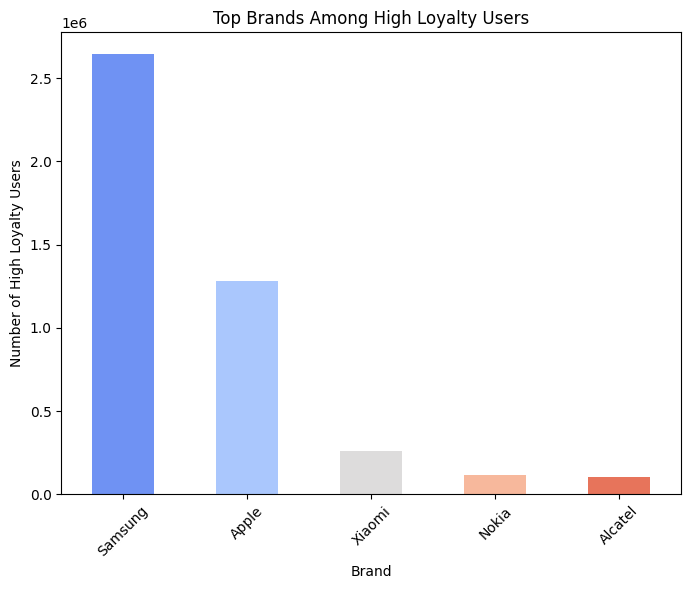

In [28]:
top_brands_high_loyalty = high_loyalty_df['BRAND'].value_counts().head(5)
coolwarm_colors = sns.color_palette("coolwarm", n_colors=5)

plt.figure(figsize=(8, 6))
top_brands_high_loyalty.plot(kind='bar', color=coolwarm_colors)

plt.title('Top Brands Among High Loyalty Users')
plt.xlabel('Brand')
plt.ylabel('Number of High Loyalty Users')
plt.xticks(rotation=45)
plt.show()

### Combining all sub-segments into one dataframe 

In [29]:
loyalty_segments_df = pd.concat([low_loyalty_df, moderate_loyalty_df, high_loyalty_df], ignore_index=True)

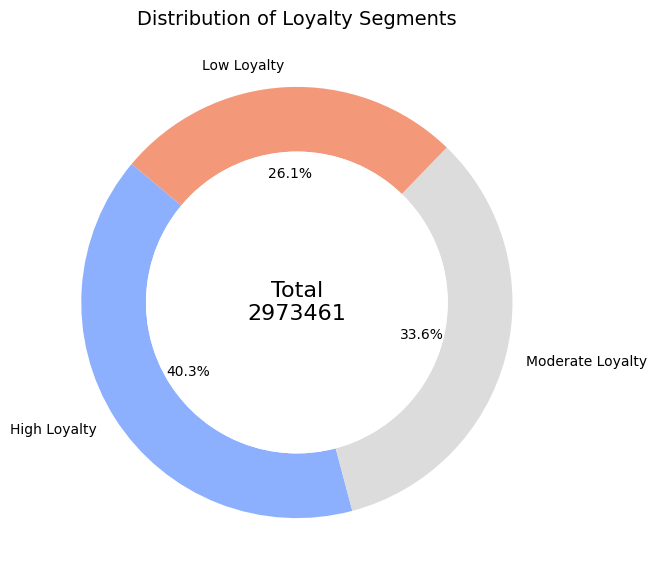

In [30]:
loyalty_distribution = loyalty_segments_df['LOYALTY_SEGMENT'].value_counts()
total_users = loyalty_segments_df['ID'].nunique()  

coolwarm_colors = sns.color_palette('coolwarm', n_colors=len(loyalty_distribution))

plt.figure(figsize=(7, 7))
plt.pie(
    loyalty_distribution, 
    labels=loyalty_distribution.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    wedgeprops=dict(width=0.3), 
    colors=coolwarm_colors
)

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.text(
    0, 0, 
    f'Total\n{total_users}', 
    ha='center', 
    va='center', 
    fontsize=16
)

plt.title('Distribution of Loyalty Segments', fontsize=14)
plt.show()

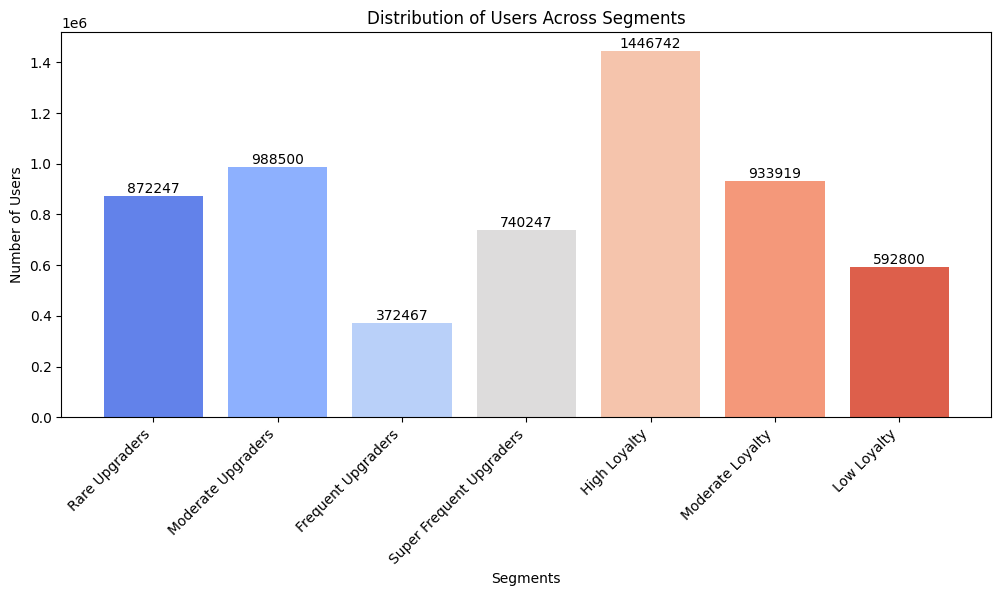

In [31]:
segment_sizes = {
    'Rare Upgraders': len(rare_df['ID'].unique()),
    'Moderate Upgraders': len(moderate_df['ID'].unique()),
    'Frequent Upgraders': len(frequent_df['ID'].unique()),
    'Super Frequent Upgraders': len(super_frequent_df['ID'].unique()),
    'High Loyalty': len(high_loyalty_df['ID'].unique()),
    'Moderate Loyalty': len(moderate_loyalty_df['ID'].unique()),
    'Low Loyalty': len(low_loyalty_df['ID'].unique())
}

fig, ax = plt.subplots(figsize=(12, 5))
bars = ax.bar(segment_sizes.keys(), segment_sizes.values(), color=sns.color_palette("coolwarm", len(segment_sizes)))

ax.set_xlabel('Segments')
ax.set_ylabel('Number of Users')
ax.set_title('Distribution of Users Across Segments')

plt.xticks(rotation=45, ha='right')

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 100, int(yval), ha='center', va='bottom')

plt.show()

In [32]:
del rare_df, moderate_df, frequent_df, super_frequent_df, low_loyalty_df, moderate_loyalty_df, high_loyalty_df

# Brand Transitions 

##### This analysis identifies brand switching behavior among customers. It calculates the number of transitions from one brand to another, allowing us to understand brand loyalty and switching patterns over time.

In [33]:
# Calculating the number of users and average days used per brand
brand_aggregation = df.groupby('BRAND').agg(
    total_users=('ID', 'nunique'), 
    avg_days_used=('DAYS_USED', 'mean')
).reset_index()

# Sorting by total_users and displaying the top 10 brands
top_brands_by_users = brand_aggregation.sort_values(by='total_users', ascending=False).head(10)
top_brands_by_users

,BRAND,total_users,avg_days_used
551,Samsung,2294979,619.626692
34,Apple,1397386,590.099574
874,Xiaomi,799450,584.552732
438,Nokia,438188,429.177260
18,Alcatel,433963,493.142015
283,Huawei,412584,618.803348
194,Fly,208794,410.337340
356,Lenovo,207254,549.972116
347,LG,150408,565.255800
249,HTC,150306,482.361531


In [34]:
transitions_df = df.copy()

# Sorting the df by 'ID' and 'START_DATE' to ensure correct order of purchases
transitions_df = transitions_df.sort_values(by=['ID', 'START_DATE'])

# Creating a new column 'PREV_BRAND' to capture the previous brand used by the same user
transitions_df['PREV_BRAND'] = transitions_df.groupby('ID')['BRAND'].shift(1)

# Creating 'BRAND_TRANSITION' column to show transitions from one brand to the next 
# This is done only when there is a previous brand available (not null)
transitions_df['BRAND_TRANSITION'] = transitions_df.apply(
    lambda x: f"{x['PREV_BRAND']} -> {x['BRAND']}" if pd.notnull(x['PREV_BRAND']) else None, axis=1
)

In [35]:
# Dropping rows where 'BRAND_TRANSITION' is null, keeping only actual transitions
transitions_only = transitions_df.dropna(subset=['BRAND_TRANSITION'])

# Grouping by 'BRAND_TRANSITION' to count the number of occurrences of each brand transition
brand_transitions = transitions_only.groupby('BRAND_TRANSITION').size().reset_index(name='COUNT')

# Selecting the top 10 most common brand transitions based on their count
top_transitions = brand_transitions.nlargest(10, 'COUNT')
top_transitions

,BRAND_TRANSITION,COUNT
17289,Samsung -> Samsung,1767063
1069,Apple -> Apple,847005
16896,Samsung -> Apple,685482
1431,Apple -> Samsung,541505
17514,Samsung -> Xiaomi,373265
23415,Xiaomi -> Samsung,206118
626,Alcatel -> Samsung,189570
14616,Nokia -> Samsung,175599
9408,Huawei -> Samsung,152388
17090,Samsung -> Huawei,142309


### Visualizing the most frequent brand switches among customers.

In [36]:
# Extracting the source and target brands from the 'BRAND_TRANSITION' column
# 'source' captures the initial brand, and 'target' captures the brand transitioned to
source = top_transitions['BRAND_TRANSITION'].apply(lambda x: x.split(' -> ')[0]).tolist()
target = top_transitions['BRAND_TRANSITION'].apply(lambda x: x.split(' -> ')[1]).tolist()

# Extracting the transition counts to represent the values for the chord diagram
values = top_transitions['COUNT'].tolist()

brand_labels = list(set(source + target))

# Initializing an adjacency matrix to represent the connections between brands
adj_matrix = pd.DataFrame(0, index=brand_labels, columns=brand_labels)

# Populating the adjacency matrix with transition values (counts) between source and target brands
for s, t, v in zip(source, target, values):
    adj_matrix.loc[s, t] = v

coolwarm_colors = sns.color_palette("coolwarm", len(values)).as_hex()

fig = go.Figure(data=go.Parcats(
    dimensions=[
        {'label': 'Source', 'values': source},
        {'label': 'Target', 'values': target},
    ],
    line={'color': values, 'colorscale': coolwarm_colors, 'shape': 'hspline'},
    hoveron='dimension',
    counts=values
))

fig.update_layout(
    title_text="Chord Diagram for Top 10 Brand Transitions",
    font_size=10,
)

fig.show()

### Visualizing the most frequent brand switches among customers, but this time excluding instances where customers remain with the same brand (self-transitions).

In [37]:
source = top_transitions['BRAND_TRANSITION'].apply(lambda x: x.split(' -> ')[0]).tolist()
target = top_transitions['BRAND_TRANSITION'].apply(lambda x: x.split(' -> ')[1]).tolist()
values = top_transitions['COUNT'].tolist()

# Filtering out self-transitions where the source and target are the same
filtered_source = []
filtered_target = []
filtered_values = []

for s, t, v in zip(source, target, values):
    if s != t:  # This line checks and excludes self-transitions (where source == target)
        filtered_source.append(s)
        filtered_target.append(t)
        filtered_values.append(v)

coolwarm = sns.color_palette("coolwarm", len(filtered_values)).as_hex()

fig = go.Figure(data=go.Parcats(
    dimensions=[
        {'label': 'Source', 'values': filtered_source},
        {'label': 'Target', 'values': filtered_target},
    ],
    line={'color': filtered_values, 'colorscale': coolwarm, 'shape': 'hspline'},
    hoveron='dimension',
    counts=filtered_values
))

fig.update_layout(
    title_text="Chord Diagram for Top 10 Brand Transitions (Excluding Self-Transitions)",
    font_size=10,
)

fig.show()

# Occasion Purchasing

##### This code identifies occasion-based purchasing behavior among customers by analyzing the sequence of device usage days. It defines short-term and long-term usage thresholds to pinpoint users who occasionally use devices for a brief period sandwiched between longer usage periods. The approach involves calculating previous and next device usage days for each customer and marking them as occasional if the current usage period is notably shorter compared to the surrounding periods. 

In [38]:
occasion_purchasing_df = df.copy()

short_term_threshold = 30
long_term_threshold = 30

occasion_purchasing_df.loc[:, 'PREV_DAYS_USED'] = occasion_purchasing_df.groupby('ID')['DAYS_USED'].shift(1)
occasion_purchasing_df.loc[:, 'NEXT_DAYS_USED'] = occasion_purchasing_df.groupby('ID')['DAYS_USED'].shift(-1)

occasion_purchasing_df.loc[:, 'IS_OCCASIONAL'] = (
    (occasion_purchasing_df['PREV_DAYS_USED'] > long_term_threshold) & 
    (occasion_purchasing_df['DAYS_USED'] < short_term_threshold) & 
    (occasion_purchasing_df['NEXT_DAYS_USED'] > long_term_threshold)
)

occasion_purchasers_df = occasion_purchasing_df[occasion_purchasing_df['IS_OCCASIONAL']].copy()
occasion_purchasers_df.loc[:, 'CATEGORY'] = 'Occasion Purchasing'


# Calculating number of occasion purchasers and their percentage
num_occasion_purchasers = occasion_purchasers_df['ID'].nunique()
total_purchasers = df['ID'].nunique()
percentage_occasion_purchasers = (num_occasion_purchasers / total_purchasers) * 100

print(f"Number of Occasion Purchasers: {num_occasion_purchasers}")
print(f"Percentage of Occasion Purchasers: {percentage_occasion_purchasers:.2f}%")

Number of Occasion Purchasers: 246995
Percentage of Occasion Purchasers: 8.31%


# Benefits Sought

##### This code identifies customers who prioritize cutting-edge technology by filtering those who own advanced devices with specific technological features. The criteria include support for 5G, LTE, and eSIM, and devices with at least 8 CPU cores, indicating high-performance preferences. Additionally, customers who adopt new devices faster than the average, based on their average days used, are further filtered to highlight frequent upgraders within this category. 

In [39]:
tech_enthusiasts_df = df[
    (df['SUPPORT_5G'] == True) &
    (df['SUPPORTS_LTE'] == True) &
    (df['SUPPORTS_ESIM'] == True) &
    (df['CPU_CORES'] >= 8)
]

# Filtering by lower than average AVG_DAYS_USED for frequent upgraders
avg_days_used_threshold = df['AVG_DAYS_USED'].mean()
tech_enthusiasts_df = tech_enthusiasts_df[tech_enthusiasts_df['AVG_DAYS_USED'] < avg_days_used_threshold]

tech_enthusiasts_df['CATEGORY'] = 'Technology Enthusiasts'

# Calculating number of technology enthusiasts and their percentage
num_tech_enthusiasts = tech_enthusiasts_df['ID'].nunique()
total_purchasers = df['ID'].nunique()
percentage_tech_enthusiasts = (num_tech_enthusiasts / total_purchasers) * 100

print(f"Number of Technology Enthusiasts: {num_tech_enthusiasts}")
print(f"Percentage of Technology Enthusiasts: {percentage_tech_enthusiasts:.2f}%")

Number of Technology Enthusiasts: 55050
Percentage of Technology Enthusiasts: 1.85%


# Final data integration - merging all segments into the final dataframe.
##### The dataframe new_df, which contains unique user IDs and their adoption category, is sequentially merged with other segmented dataframes (purchasing_behavior_df, loyalty_segments_df, tech_enthusiasts_df, occasion_purchasers_df). Each merge incorporates specific behavioral and loyalty categories, ensuring that all relevant segmentation information is consolidated into a single, comprehensive dataframe. 
##### This final merged dataframe provides a holistic view of each customer's behavior, loyalty, and purchasing patterns, enabling a robust analysis of customer segments.

In [40]:
purch_behavior = purchasing_behavior_df.sort_values(by=['ID', 'START_DATE'], ascending=[True, False]).drop_duplicates(subset=['ID'])

final_df = pd.merge(
    new_df, 
    purch_behavior[['ID', 'CATEGORY']].rename(columns={'CATEGORY': 'UPGRADE_CATEGORY'}), 
    on='ID', 
    how='left'
)

In [41]:
loyalty_latest = loyalty_segments_df.sort_values(by=['ID', 'START_DATE'], ascending=[True, False]).drop_duplicates(subset=['ID']) if 'START_DATE' in loyalty_segments_df.columns else loyalty_segments_df

final_df = pd.merge(
    final_df, 
    loyalty_latest[['ID', 'LOYALTY_SEGMENT']].rename(columns={'LOYALTY_SEGMENT': 'LOYALTY_CATEGORY'}), 
    on='ID', 
    how='left'
)

In [42]:
tech_latest = tech_enthusiasts_df.sort_values(by=['ID', 'START_DATE'], ascending=[True, False]).drop_duplicates(subset=['ID']) if 'START_DATE' in tech_enthusiasts_df.columns else tech_enthusiasts_df


final_df = pd.merge(
    final_df, 
    tech_latest[['ID', 'CATEGORY']].rename(columns={'CATEGORY': 'TECH_CATEGORY'}), 
    on='ID', 
    how='left'
)

In [43]:
occasion_latest = occasion_purchasers_df.sort_values(by=['ID', 'START_DATE'], ascending=[True, False]).drop_duplicates(subset=['ID']) if 'START_DATE' in occasion_purchasers_df.columns else occasion_purchasers_df

final_df = pd.merge(
    final_df, 
    occasion_latest[['ID', 'CATEGORY']].rename(columns={'CATEGORY': 'OCCASION_CATEGORY'}), 
    on='ID', 
    how='left'
)

In [44]:
# Converting `OCCASION_CATEGORY` and `TECH_CATEGORY` to binary indicators
final_df['IS_OCCASION_PURCHASER'] = final_df['OCCASION_CATEGORY'].notna().astype(int)
final_df['IS_TECH_ENTHUSIAST'] = final_df['TECH_CATEGORY'].notna().astype(int)

final_df = final_df.drop(['OCCASION_CATEGORY', 'TECH_CATEGORY'], axis=1)
final_df.shape

(2972988, 41)

In [45]:
del purchasing_behavior_df, loyalty_segments_df, occasion_purchasers_df, tech_enthusiasts_df

In [46]:
final_df.head()


,ID,DEVICE_ID,BRAND,MODEL,NETTYPE,OS,OS_TYPE_x,DEVICE_AGE,RELEASE_DATE,START_DATE,END_DATE,DAYS_USED,AVG_DAYS_USED,SUPPORTS_LTE,SUPPORTS_VOLTE,BATTERY_CAPACITY,BATTERY_TYPE,BODY_DEPTH,BODY_HEIGHT,BODY_WIDTH,BODY_TYPE,OS_TYPE_y,OS_VENDOR,CAMERA_FLASHLIGHT,SUPPORTS_MULTISIM,SUPPORTS_ESIM,SUPPORT_5G,SIM_COUNT,CPU_CORES,MULTISIM_MODE,PIXEL_DENSITY,RAM_SIZE,BAND_1800,BAND_1900,BAND_850,BAND_900,ADOPTER_CATEGORY,UPGRADE_CATEGORY,LOYALTY_CATEGORY,IS_OCCASION_PURCHASER,IS_TECH_ENTHUSIAST
0,1,35579407,Apple,iPhone SE,4G,iOS,smartphone,486,2016-03-01,2017-06-30,2019-10-31,882,642.5,1,0,1642.0,Li-ion,7.60,123.80,58.60,touch,iOS,Apple,1,0,0,0,1,8,Standby,326.0,2048,1,1,1,1,Mid-range Adopter,Rare Upgraders,High Loyalty,0,0
1,2,86221906,Xiaomi,Redmi 12,4G,Android,smartphone,392,2023-01-04,2024-01-31,2024-07-12,193,226.1,1,1,5000.0,Li-ion,8.17,168.60,76.28,touch,Android,Google,0,1,0,0,2,8,dual standby,396.0,4096,1,1,1,1,Mid-range Adopter,Super Frequent Upgraders,Low Loyalty,0,0
2,5,86095705,Xiaomi,Redmi 9,4G,Android,smartphone,1247,2020-04-01,2023-08-31,2024-07-12,346,645.2,1,1,5020.0,Li-ion,9.10,163.32,77.01,touch,Android,Google,1,1,0,0,2,8,Standby,395.0,3072,1,1,1,1,Late Adopter,Moderate Upgraders,High Loyalty,0,0
3,6,86252506,Xiaomi,Redmi 9C,4G,Android,smartphone,791,2020-07-31,2022-09-30,2024-07-12,680,559.1,1,1,5000.0,Li-polymer,9.00,164.90,77.00,touch,Android,Google,1,1,0,0,2,8,dual standby,269.0,2048,1,1,1,1,Late Adopter,Moderate Upgraders,Low Loyalty,0,0
4,7,35657309,Samsung,Galaxy A3 2017,4G,Android,smartphone,2310,2017-01-01,2023-04-30,2024-07-12,468,730.3,1,0,2350.0,Li-ion,7.90,135.40,66.20,touch,Android,Google,1,0,0,0,1,8,Standby,312.0,2048,1,1,1,1,Laggard,Moderate Upgraders,High Loyalty,0,0


In [47]:
df[df['ID'] == 2738751]

,ID,DEVICE_ID,BRAND,MODEL,NETTYPE,OS,OS_TYPE_x,START_DATE,END_DATE,DAYS_USED,AVG_DAYS_USED,SUPPORTS_LTE,SUPPORTS_VOLTE,BATTERY_CAPACITY,BATTERY_TYPE,BODY_DEPTH,BODY_HEIGHT,BODY_WIDTH,BODY_TYPE,OS_TYPE_y,OS_VENDOR,CAMERA_FLASHLIGHT,SUPPORTS_MULTISIM,SUPPORTS_ESIM,SUPPORT_5G,SIM_COUNT,CPU_CORES,MULTISIM_MODE,PIXEL_DENSITY,RAM_SIZE,RELEASE_DATE,BAND_1800,BAND_1900,BAND_850,BAND_900,DEVICE_AGE,DEVICE_COUNT
1001455,2738751,35441105,Samsung,Galaxy S II Lite,3G,Android,smartphone,2016-11-30,2017-11-30,394,460.0,0,0,1500.0,Li-ion,9.69,123.20,63.0,touch,Android,Google,1,0,0,0,1,8,Standby,233.0,768,2012-01-01,1,1,1,1,1795,6
2488236,2738751,35960910,Samsung,Galaxy A40 Dual,4G,Android,smartphone,2019-10-31,2020-05-31,243,737.9,1,1,3100.0,Li-polymer,7.90,144.30,69.1,touch,Android,Google,1,1,0,0,2,8,dual standby,428.0,4096,2019-04-01,1,1,1,1,213,6
5165365,2738751,35733606,HTC,One M8,4G,Android,smartphone,2017-08-31,2017-10-31,91,581.8,1,1,2600.0,Li-polymer,9.35,146.36,70.6,touch,Android,Google,1,0,0,0,1,4,Standby,441.0,2048,2014-03-01,1,1,1,1,1279,6
6485653,2738751,86610503,Huawei,Honor 7X,4G,Android,smartphone,2017-12-31,2020-06-30,942,710.4,1,1,3240.0,Li-ion,7.60,156.50,75.3,touch,Android,Google,1,1,0,0,2,8,Standby,407.0,4096,2017-10-01,1,1,1,1,91,6
9870489,2738751,35700428,Apple,iPhone 15,5G,iOS,smartphone,2023-10-31,2024-07-12,285,154.5,1,1,3349.0,Li-polymer,7.80,147.60,71.6,touch,iOS,Apple,1,1,1,1,0,6,Standby,461.0,6144,2023-09-12,1,1,1,1,49,6
9892439,2738751,35290811,Apple,iPhone 11,4G,iOS,smartphone,2020-07-31,2023-09-30,1186,543.8,1,1,3110.0,Li-ion,8.30,150.90,75.7,touch,Apple iOS,Apple,1,1,1,0,1,8,Standby,324.0,4096,2019-09-11,1,1,1,1,324,6


In [48]:
final_df[final_df['ID'] == 2738751]

,ID,DEVICE_ID,BRAND,MODEL,NETTYPE,OS,OS_TYPE_x,DEVICE_AGE,RELEASE_DATE,START_DATE,END_DATE,DAYS_USED,AVG_DAYS_USED,SUPPORTS_LTE,SUPPORTS_VOLTE,BATTERY_CAPACITY,BATTERY_TYPE,BODY_DEPTH,BODY_HEIGHT,BODY_WIDTH,BODY_TYPE,OS_TYPE_y,OS_VENDOR,CAMERA_FLASHLIGHT,SUPPORTS_MULTISIM,SUPPORTS_ESIM,SUPPORT_5G,SIM_COUNT,CPU_CORES,MULTISIM_MODE,PIXEL_DENSITY,RAM_SIZE,BAND_1800,BAND_1900,BAND_850,BAND_900,ADOPTER_CATEGORY,UPGRADE_CATEGORY,LOYALTY_CATEGORY,IS_OCCASION_PURCHASER,IS_TECH_ENTHUSIAST
1665384,2738751,35700428,Apple,iPhone 15,5G,iOS,smartphone,49,2023-09-12,2023-10-31,2024-07-12,285,154.5,1,1,3349.0,Li-polymer,7.8,147.6,71.6,touch,iOS,Apple,1,1,1,1,0,6,Standby,461.0,6144,1,1,1,1,Innovator,Super Frequent Upgraders,Low Loyalty,0,0


: 